# Kickstarting the Martian Greenhouse Effect
## A Final Project for Physics 361 by Morgan Baxter and Alex Brovender

For a variety of reasons, including proximity to the sun and atmospheric and regolith composition, Mars is the number one candidate body in the solar system for future human colonization. Despite this status, there are many hurdles which humans will need to overcome in order to permanantly colonize Mars. One of the key problems is the extreme temperature variation. In order to increase the thermal inertia of the atmosphere and generally increase the average temperature, we propose a model where a large amount of CO2 is released suddenly into the atmosphere, with the intention of increasing the temperature at the poles. The Martian ice caps have a considerable amount of CO2 that, if liberated, is likely to further increase this greenhouse effect, and therefore continue to warm the planet. We use simple climate models to find the amount of energy that would be required to liberate enough CO2 to kickstart this greenhouse effect.

<div>
<img src="https://upload.wikimedia.org/wikipedia/commons/6/6a/PIA22546-Mars-AnnualCO2ice-N%26SPoles-20180806.gif" width="500"/>
</div>
$\textbf{Figure 1:}$ Extents of north (left) and south (right) polar CO2 ice during a martian year

$\textbf{Source:}$ NASA/JPL-caltech




## Hogg 2008: Glacial cycles and carbon dioxide: A conceptual model

We utilize Hogg, 2008, as a starting point for our model for the Mars climate system. The equations as he provides them are as follows:

$$ c\frac{dT}{dt} = \bar{S} + \sum_i{sin \left (\frac{2 \pi t}{\Gamma_i}\right )} + \bar{G} + A \ln \left(\frac{C}{C_0}\right) - \sigma T^4$$

$$ \frac{dC}{dt} = V - (W_0 + W_1C) + \beta (C_{max} - C)\max\left(\frac{dT}{dt} - \epsilon , 0 \right) $$

These equations in their current form are not useful to us for a variety of reasons. They include terms that account for volcanic activity, the carbon sink of the oceans, orbital pertubations, and the heat capacity of the oceans. As a result, the coupled differential equations that we will use look slightly different. However, they do take a variety of the the phenomena we want to observe into account, so they are a good starting point.

## Modified Equations

Our reduced equations look as follows:

$$ \frac{dT}{dt} = \Big[ \bar{S} + \bar{G} + A \ln \left(\frac{C}{C_0}\right) - 4\sigma T^4 \Big] /c$$

$$\frac{dC}{dt} = (T^* - 140)\beta$$

Our state variables are $T$, the average surface temperature in Kelvin, and $C$, the mass of CO2 in the Martian atmosphere, in kilograms. Therefore, our parameters must match these units, and we list them below:

$\beta$ is the rate of carbon effect on temperature. It has units of $kg \cdot s^{-1} K^{-1}$.

$T^*$ is the temperature $\textbf{at the poles}$ in Kelvin. This will vary by a set offset $\textbf{NOT YET DETERMINED}$ that will solve issues relating to the average temperature on Mars being more than warm enough to sublimate CO2 at the given pressure.

$\bar{S}$ is the rate of incoming solar radiation. This value is $589 W \cdot m^{-2}$

$\bar{G}$ is the greenhouse warming term. This should initially be on the order of $1 W \cdot m^{-2}$

$A$ represents the effect of CO2 on the radiation budget. It should be set to $5.35 W \cdot m^{-2}$. Might want to play around with this value. Hogg cites a paper that seems to detail where this value comes from.

$\frac{C}{C_0}$ represents the ratio between the mass of the CO2 currently in the atmosphere compared to the initial value. It is dimensionless.

$\sigma$ is the Stefan-Boltzmann constant, which is equal to $\frac{2 \pi^5 k^4}{15c^2 h^3} = 5.67 *10^{-8} W m^{-2} K^{-4}$.

$c$ is the specific heat capacity of CO2. We will take this to be approximately $700 J \cdot kg^{-1} \cdot K^{-1}$. This is a function of temperature and pressure, and therefore it could be more accurate to have this in function form rather than as a constant.

These two equations are enough for us to solve the system. However, it is worth taking some time to consider problems with temperature variation and CO2 sublimation. At the pressures experiences on the Martian surface, the sublimation temperature of CO2 is -125 Celsius, or 140 Kelvin. However, according to the solar radiation equation, the equlibrium temperature of Mars is 215 Kelvin. Therefore, to take this discrepency into account, we will generate a distribution function that represents the variation of temperature on Mars as we change Latitude.

The average of this distribution will be our $T$ value, which will start at 215 Kelvin. Our value at the poles, $T*$, will be 140 Kelvin. This means our initial temperature at the equator is 290 Kelvin, which is in agreement with measurements taken from Martian landers. The code below defines this distribution. When $T$ changes, the entire distribution will shift up, so the temperature of the entire planet will change an equal amount. From this distribution, our equation for the temperature as a function of $\phi$ is:

$$\gamma(\phi) = j E^{-\left (2 \left(\phi-\frac{\pi}{2} \right) \right) ^2} + T^*$$

The average temperature can therefore be written as $T = T^* + j/2$, so to get back out our parameter $j$, we can rewrite this as:

$$j = \frac{T-T^*}{2}$$

$$T^* = T - \frac{j}{2}$$

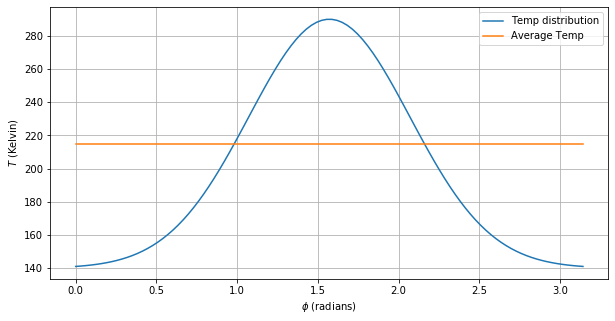

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams["figure.figsize"] = (10,5)

latitude = np.linspace(0,np.pi,100)
temperature = 150*np.exp(-2*(latitude - (np.pi/2))**2)+140
plt.xlabel('$\phi$ (radians)')
plt.ylabel('$T$ (Kelvin)')
plt.grid()
plt.plot(latitude,temperature,label='Temp distribution')
plt.plot(latitude,np.linspace(215,215,100), label='Average Temp')
plt.legend()

In [55]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.integrate as integ

# here we define our constants and put them in a list to hand to the Euler's method routine
SB_constant = 5.67e-8
solar_constant = 589
#solar_constant = 0
G = 1
A = 5.35

# just to make euler's method work, will change later, but not a bad value, guessed at initial T and C values, ADJUST LATER
T_0 = 215      
C_0 = 1e16
beta = 0.001

Now we have our function for the system of differential equations, a list containing our parameters, and initial guesses for starting temperature and atmospheric carbon content. From here, we use the Euler method to solve this system.

In [58]:
# Euler's method for T, stepsize t:

t = 0.0
dt = 1.0
T = T_0
C = C_0

C_list = []
T_list = []

for i in range(500):
    
    # appends new data points to list
    C_list.append(C)
    T_list.append(T)
    
    # defines the RHS for both differential equations
    dT = (solar_constant + G + (A*np.log(C/C_0)) - 4*(SB_constant*(T**4)))/700
    dC = ((T-75) - 140)*beta
    
    # carries out Euler's method
    C = C + dC*dt
    T = T + dT*dt
    
    # adds dt to t before next loop
    t = t + dt

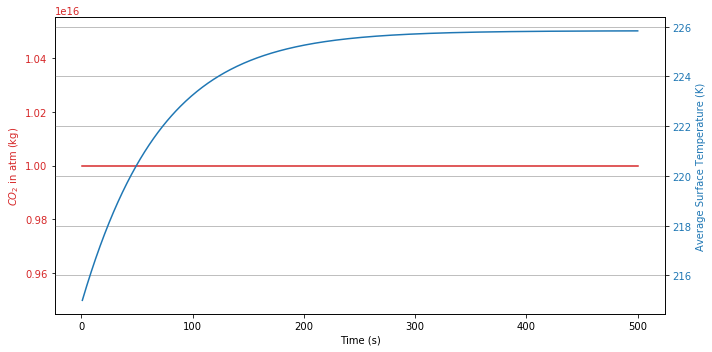

In [59]:
x_values = np.linspace(1,500,500)
plt.rcParams["figure.figsize"] = (10,5)

data1 = np.exp(t)
data2 = np.sin(2 * np.pi * t)

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('$CO_2$ in atm (kg)', color=color)
ax1.plot(x_values, C_list, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Average Surface Temperature (K)', color=color)  # we already handled the x-label with ax1
ax2.plot(x_values, T_list, color=color)
ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.grid()
plt.show()